<a href="https://colab.research.google.com/github/FKz11/NN_PyTorch/blob/main/lesson_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-7

### Библиотеки:

In [1]:
pip install -qq stop-words

In [2]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download("punkt")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from string import ascii_lowercase
from stop_words import get_stop_words
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## 1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

### Данные

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/archive.zip'

In [6]:
df = pd.read_csv('/content/train.csv')
df.drop('id', axis=1, inplace=True)
df.tail()

,label,tweet
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,0,thank you @user for you follow


#### train_test_split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df.tail()

,label,tweet
22368,0,#waltdisneyreso should be ashamed of themselv...
22369,0,@user invited @user over for a catch up and i...
22370,1,black professor makes assumptions about an ent...
22371,0,#lgbtqhatetrumppay is total #liberal trash. it...
22372,0,what makes people is relative. we have our w...


In [8]:
train_df['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [9]:
disbalance = train_df['label'].value_counts()[0] / train_df['label'].value_counts()[1]
disbalance

13.36007702182285

Видно, что у нас есть сильный дизбаланс классов

### Предобработка

Стоп слова, которые не несут большой смысловой нагрузки

In [10]:
sw = set(get_stop_words('en'))
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

Обозначим возможные символы

In [11]:
ascii_plus = ascii_lowercase + " "
ascii_plus

'abcdefghijklmnopqrstuvwxyz '

In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizer.lemmatize('feet')

'foot'

Предобработка текста

In [13]:
def preprocess_text(txt, ascii_plus, lemmatizer):
    txt = txt.lower()
    txt = "".join(s for s in txt if s in ascii_plus)
    txt = " ".join(lemmatizer.lemmatize(word) for word in txt.split() if word not in sw)
    return txt

In [14]:
train_df['tweet'][1]

'dese niggas will show dese otha bitches on fb, snap nd twitter more attention then dey do their own girl   but #true ð\x9f\x92¯'

In [15]:
preprocess_text(train_df['tweet'][1], ascii_plus, lemmatizer)

'dese nigga will show dese otha bitch fb snap nd twitter attention dey girl true'

In [16]:
train_df['tweet'].tail()

22368    #waltdisneyreso  should be ashamed of themselv...
22369     @user invited @user over for a catch up and i...
22370    black professor makes assumptions about an ent...
22371    #lgbtqhatetrumppay is total #liberal trash. it...
22372    what makes people   is relative. we have our w...
Name: tweet, dtype: object

In [17]:
train_df['tweet_preprocess'] = train_df['tweet'].apply(lambda txt: preprocess_text(txt, ascii_plus, lemmatizer))
test_df['tweet_preprocess'] = test_df['tweet'].apply(lambda txt: preprocess_text(txt, ascii_plus, lemmatizer))
train_df['tweet_preprocess'].tail()

22368    waltdisneyreso ashamed knew alligator beach si...
22369    user invited user catch couldnt stop talking m...
22370    black professor make assumption entire race wh...
22371    lgbtqhatetrumppay total liberal trash amp path...
22372                      make people relative way africa
Name: tweet_preprocess, dtype: object

Сравнивая токенизацию и split, находим, что они отличаются только в 162 примерах

In [18]:
train_df['tweet_preprocess'].apply(lambda txt: nltk.tokenize.word_tokenize(txt) != txt.split()).sum()

162

In [19]:
j = 0
for i in train_df['tweet_preprocess'].apply(lambda txt: nltk.tokenize.word_tokenize(txt) != txt.split()):
  if i:
    print(j)
    break
  j +=1

136


In [20]:
train_df['tweet_preprocess'][j]

'now see come friday gotta go see'

In [21]:
train_df['tweet_preprocess'][j].split()

['now', 'see', 'come', 'friday', 'gotta', 'go', 'see']

In [22]:
nltk.tokenize.word_tokenize(train_df['tweet_preprocess'][j])

['now', 'see', 'come', 'friday', 'got', 'ta', 'go', 'see']

Видно, что токенизация даёт ненужные новые сущности, разделяя такие слова как gotta, чего нам бы не хотелось

In [23]:
train_df['tweet_split'] = train_df['tweet_preprocess'].apply(lambda txt: txt.split())
test_df['tweet_split'] = test_df['tweet_preprocess'].apply(lambda txt: txt.split())
train_df['tweet_split'].tail()

22368    [waltdisneyreso, ashamed, knew, alligator, bea...
22369    [user, invited, user, catch, couldnt, stop, ta...
22370    [black, professor, make, assumption, entire, r...
22371    [lgbtqhatetrumppay, total, liberal, trash, amp...
22372                [make, people, relative, way, africa]
Name: tweet_split, dtype: object

In [24]:
tokens = dict()

for txt in train_df['tweet_split']:
  for word in txt:
    tokens[word] = tokens.get(word, 0) + 1

sorted_tokens = sorted(tokens, key=tokens.get, reverse=True)

In [25]:
for i in range(10):
  print(sorted_tokens[i], tokens[sorted_tokens[i]])

user 12225
day 1968
love 1937
happy 1203
u 1174
amp 1122
just 941
will 883
life 879
time 863


In [26]:
len(sorted_tokens)

29703

In [27]:
VOCABULARY_SIZE = 10000
VOCABULARY_SIZE

10000

Возьмём из токенов первые VOCABULARY_SIZE-1 элементов, так как у нас будет ещё один элемент 0, обозначающий отсутсвие слова

In [28]:
vocabulary = {w: i for i, w in enumerate(sorted_tokens[:VOCABULARY_SIZE-1], 1)}
for i in list(vocabulary.keys())[:10]:
  print(i, vocabulary[i])

user 1
day 2
love 3
happy 4
u 5
amp 6
just 7
will 8
life 9
time 10


In [29]:
sorted_tokens[VOCABULARY_SIZE-2], tokens[sorted_tokens[VOCABULARY_SIZE-2]]

('matte', 2)

Последний взятый токен встречался всего 2 раза, значит можно предположить, что наш словарь имеет почти все информативные слова

In [30]:
train_df['tweet_split'].apply(lambda txt: len(txt)).max()

24

In [31]:
train_df['tweet_split'].apply(lambda txt: len(txt)).mean()

8.448263531935815

In [32]:
MAX_LEN = 10
MAX_LEN

10

Такой максимальной длиной мы довольно хорошо описываем наши примеры, так как она больше средней, при этом не перегружаем модель, как если бы мы брали максимальную длину примеров

Приведём данные к числовым векторам одинаковой длины

In [33]:
def text_to_sequence(txt, vocabulary, max_len):
  response = []
  for w in txt:
    if w in vocabulary.keys():
      response.append(vocabulary[w])
    if len(response) == max_len:
      break
  response += [0]*(max_len-len(response))
  return response

In [34]:
train_df['tweet_vocabulary'] = train_df['tweet_split'].apply(lambda txt: text_to_sequence(txt, vocabulary, MAX_LEN))
test_df['tweet_vocabulary'] = test_df['tweet_split'].apply(lambda txt: text_to_sequence(txt, vocabulary, MAX_LEN))
train_df['tweet_vocabulary'].tail()

22368          [2086, 1127, 1202, 200, 619, 1, 0, 0, 0, 0]
22369        [1, 2750, 1, 1508, 639, 135, 657, 78, 3, 205]
22370    [126, 20, 1002, 393, 2116, 1953, 1002, 393, 90...
22371           [1511, 353, 2410, 6, 705, 383, 0, 0, 0, 0]
22372              [20, 21, 3169, 43, 1487, 0, 0, 0, 0, 0]
Name: tweet_vocabulary, dtype: object

### Создание модели

Используем  lstm слой

In [35]:
class Net(nn.Module):
    def __init__(self, max_len, vocab_size, embedding_dim, padding_idx, 
                 hidden_dim, num_classes, dropout, num_layers, use_last):
        super().__init__()
        self.use_last = use_last
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.bn_1 = nn.BatchNorm1d(hidden_dim)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn_2 = nn.BatchNorm1d(hidden_dim // 2)
        self.linear_2 = nn.Linear(hidden_dim // 2, num_classes)

        self.relu = nn.ReLU()
        self.dp = nn.Dropout(dropout)
        
    def forward(self, x):        
        output = self.embedding(x)
        output = self.dp(output)
        lstm_out, ht = self.lstm(output)
        if self.use_last:
            output = lstm_out[:,-1,:]
        else:
            # use mean
            output = torch.mean(lstm_out[:,:,:], dim=1)
        output = self.bn_1(output)
        output = self.dp(output)

        output = self.linear_1(output)
        output = self.bn_2(output)
        output = self.relu(output)
        output = self.dp(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [36]:
model = Net(max_len=MAX_LEN, vocab_size=VOCABULARY_SIZE, embedding_dim=128, padding_idx=0, 
                 hidden_dim=128, num_classes=1, dropout=0.0, num_layers=1, use_last=False)

In [37]:
sum([param.nelement() for param in model.parameters()])

1420801

### Dataset

In [38]:
class DataWrapper(Dataset):
    def __init__(self, data, target):
        data_numpy = np.array([[j for j in i] for i in data])
        self.data = torch.from_numpy(data_numpy).long()
        self.target = torch.from_numpy(target).long()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
            
        return x, y
    
    def __len__(self):
        return len(self.target)

In [39]:
train_data = DataWrapper(train_df['tweet_vocabulary'].values, train_df['label'].values)
test_data = DataWrapper(test_df['tweet_vocabulary'].values, test_df['label'].values)

### DataLoader

In [40]:
train_loader = DataLoader(train_data, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=True)

### Обучение

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Напишем собственный Loss для учёта дизбаланса классов, умножая потери по положительному классу на степень дизбаланса

In [42]:
def BCE_weigh(weight=1):

  def loss(input, target):
    input = torch.clamp(input,min=1e-7,max=1-1e-7)
    target = torch.clamp(target,min=1e-7,max=1-1e-7)
    bce = - weight * target * torch.log(input) - (1 - target) * torch.log(1 - input)
    return torch.mean(bce)

  return loss

In [43]:
model = model.to(device)
model.train()

Net(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dp): Dropout(p=0.0, inplace=False)
)

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = BCE_weigh(weight=disbalance)

In [45]:
epochs = 10
threshold = 0.8

train_history_loss = []
test_history_loss = []
test_history_acc= []
test_history_f1 = []
test_history_pr_auc = []

mean_best_threshold = 0.0

for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    test_acc = 0.0
    test_f1 = 0.0
    test_pr_auc = 0.0
    best_threshold = 0.0

    for data in train_loader:

      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      labels = labels[..., None].float()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    for data in test_loader:
      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = model(inputs)
      labels = labels[..., None].float()
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      response = outputs.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy().astype(int)

      precision, recall, thresholds = precision_recall_curve(labels, response)
      test_pr_auc += auc(recall, precision)

      best_threshold += thresholds[((precision * recall) / (precision + recall + 1e-7)).argmax()]

      response_int = (response > threshold).astype(int)

      test_acc += (response_int == labels).sum() / len(labels)
      test_f1 += f1_score(labels, response_int)

    mean_best_threshold += best_threshold

    print(f'Epoch: {epoch + 1}; '\
            f'Train_loss: {round(train_loss / len(train_loader), 3)}; '\
            f'Test_loss: {round(test_loss / len(test_loader), 3)}; '\
            f'Test_acc: {round(test_acc / len(test_loader), 3)}; '\
            f'Best_threshold: {round(best_threshold / len(test_loader), 3)}; '\
            f'Test_pr_auc: {round(test_pr_auc / len(test_loader), 3)}; '\
            f'Test_f1: {round(test_f1 / len(test_loader), 3)}')
    
    train_history_loss.append(train_loss / len(train_loader))
    test_history_loss.append(test_loss / len(test_loader))
    test_history_acc.append(test_acc / len(test_loader))
    test_history_f1.append(test_f1 / len(test_loader))
    test_history_pr_auc.append(test_pr_auc / len(test_loader))

mean_best_threshold = mean_best_threshold / (len(test_loader) * epochs)
print(f'Best_threshold: {round(mean_best_threshold, 3)}')

Epoch: 1; Train_loss: 0.961; Test_loss: 0.762; Test_acc: 0.942; Best_threshold: 0.768; Test_pr_auc: 0.578; Test_f1: 0.536
Epoch: 2; Train_loss: 0.476; Test_loss: 0.748; Test_acc: 0.944; Best_threshold: 0.842; Test_pr_auc: 0.668; Test_f1: 0.611
Epoch: 3; Train_loss: 0.214; Test_loss: 1.118; Test_acc: 0.946; Best_threshold: 0.884; Test_pr_auc: 0.682; Test_f1: 0.623
Epoch: 4; Train_loss: 0.105; Test_loss: 1.359; Test_acc: 0.948; Best_threshold: 0.863; Test_pr_auc: 0.677; Test_f1: 0.633
Epoch: 5; Train_loss: 0.061; Test_loss: 1.694; Test_acc: 0.95; Best_threshold: 0.817; Test_pr_auc: 0.685; Test_f1: 0.636
Epoch: 6; Train_loss: 0.037; Test_loss: 1.947; Test_acc: 0.949; Best_threshold: 0.851; Test_pr_auc: 0.662; Test_f1: 0.626
Epoch: 7; Train_loss: 0.027; Test_loss: 1.941; Test_acc: 0.945; Best_threshold: 0.911; Test_pr_auc: 0.673; Test_f1: 0.616
Epoch: 8; Train_loss: 0.016; Test_loss: 2.108; Test_acc: 0.952; Best_threshold: 0.78; Test_pr_auc: 0.68; Test_f1: 0.638
Epoch: 9; Train_loss: 0.011

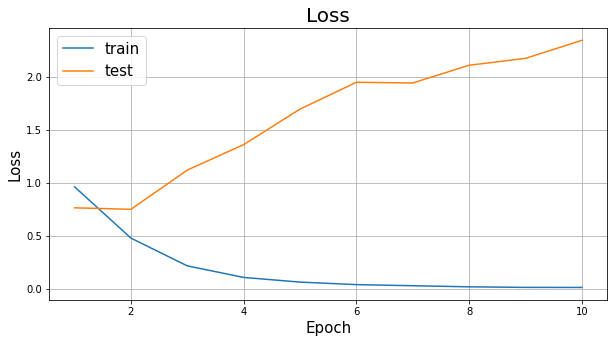

In [46]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, epochs+1), train_history_loss, label='train')
plt.plot(range(1, epochs+1), test_history_loss, label='test')
plt.legend(fontsize = 15);

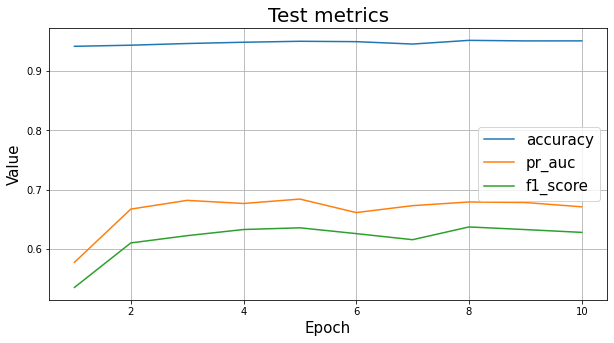

In [48]:
plt.figure(figsize = (10,5))

plt.title('Test metrics', fontsize = 20)
plt.grid(True)
plt.ylabel('Value', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, epochs+1), test_history_acc, label='accuracy')
plt.plot(range(1, epochs+1), test_history_pr_auc, label='pr_auc')
plt.plot(range(1, epochs+1), test_history_f1, label='f1_score')
plt.legend(fontsize = 15);

## 2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

Сравнивая результат с результатом модели на свёртках, можно увиделть, что:

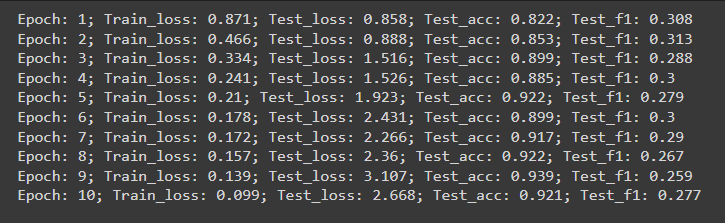

Train_loss меньше, значит модель быстрее обучается.

Test_loss меньше, значит модель медленнее переобучается.

Test_acc мы не будем сравнивать, так как эта метрика будет большой даже если модель для всех примеров предсказывает 0.

Test_f1 увеличился более чем вдвое!!! И теперь имеет хороший показатель, больше 0.62, это значит, что наша модель хорошо справилась со своей задачей.

Настройка гиперпараметров и замена свёрток на lstm слой совсем немного увеличили test_f1, до 0.32.

Основное что помогло, это я заметил, что в некоторых batch получалось так, что 
все labels были с нулевой меткой, естественно модель на таких примерах не обучалась, а их было много, метка 1 в среднем встречается 1 раз в 14 примерах, а batch size был равен 16. Когда я увеличил batch size до 2048 на train и до 1024 на test, метрика подскочила в два раза и больше таких пакетов, где были только нулевые метки, не было.

Так же я добавил еще одну метрику, pr_auc, так как у нас есть сильный дисбаланс классов, то threshold = 0.5, уже не является оптимумом. Доказательство этому, вычисленный best_threshold, который равен 0.844, а не 0.5. А при вычислении pr_auc, мы перебираем все threshold и находим площадь под графиком. Я выбрал pr_auc, а не roc_auc, так как метрика roc_auc из-за сильного дисбаласна классов была бы слишком оптимистичная, из-за того, что у нас очень много нулевых меток, false positive rate был бы очень маленьким, хотя мы и ошибаемся, ставя метки 1, где они на самом деле 0. Поэтому я выбрал precision вместо false positive rate, то есть pr_auc вместо roc_auc. Хотя и pr_auc больше смотрит на то, как мы предсказываем класс 1, а не в целом оба класса, нас как раз таки это и устраивает.

pr_auc так же имеет хороший показатель, больше 0.67